### (3.0) Korzystając z podanych wyżej funkcji ukryć dowolną wiadomość w dowolnym obrazku.

In [ ]:
"""Function definitions that are used in LSB steganography."""
from matplotlib import pyplot as plt
import numpy as np
import binascii
import cv2 as cv
import math
import struct
import itertools 
plt.rcParams["figure.figsize"] = (18,10)


def encode_as_binary_array(msg):
    """Encode a message as a binary string."""
    msg = msg.encode("utf-8")
    msg = msg.hex()
    msg = [msg[i:i + 2] for i in range(0, len(msg), 2)]
    msg = [bin(int(el, base=16))[2:] for el in msg]
    msg = ["0" * (8 - len(el)) + el for el in msg]
    return "".join(msg)


def decode_from_binary_array(array):
    """Decode a binary string to utf8."""
    array = [array[i:i+8] for i in range(0, len(array), 8)]
    if len(array[-1]) != 8:
        array[-1] = array[-1] + "0" * (8 - len(array[-1]))
    array = [hex(int(el, 2))[2:].zfill(2) for el in array]
    array = "".join(array)
    result = binascii.unhexlify(array)
    return result.decode("utf-8", errors="replace")


def load_image(path, pad=False):
    """Load an image.
    
    If pad is set then pad an image to multiple of 8 pixels.
    """
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    if pad:
        y_pad = 8 - (image.shape[0] % 8)
        x_pad = 8 - (image.shape[1] % 8)
        image = np.pad(
            image, ((0, y_pad), (0, x_pad) ,(0, 0)), mode='constant')
    return image


def save_image(path, image):
    """Save an image."""
    plt.imsave(path, image) 


def clamp(n, minn, maxn):
    """Clamp the n value to be in range (minn, maxn)."""
    return max(min(maxn, n), minn)


def hide_message(image, message, nbits=1):
    """Hide a message in an image (LSB).
    
    nbits: number of least significant bits
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > len(image) * nbits:
        raise ValueError("Message is to long :(")
    
    print('secret: {}, nbits: {}, len_img * nbits = {}, stosunek: {} %'.format(len(message),nbits, len(image)*nbits, 100*len(message)/(len(image)*nbits)))
    
    chunks = [message[i:i + nbits] for i in range(0, len(message), nbits)]
    count = 0
    tmp = 0
    MSE = 0
    for i, chunk in enumerate(chunks):
        byte = str(bin(image[i]))[2:].zfill(8)
        new_byte = byte[:-nbits] + chunk
        image[i] = int(new_byte, 2) 
        tmp += pow(int(byte,2) - int(new_byte,2), 2)
        count = count + 1
    MSE = tmp/count
    print('MSE = {}'.format(MSE))
    return image.reshape(shape), MSE


def reveal_message(image, nbits=1, length=0):
    """Reveal the hidden message.
    
    nbits: number of least significant bits
    length: length of the message in bits.
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image)
    
    message = ""
    i = 0
    while i < length_in_pixels:
        byte = str(bin(image[i]))[2:].zfill(8)
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message

secret: 160, nbits: 2, len_img * nbits = 5695200, stosunek: 0.0028093833403567917 %
MSE = 2.3625
Zostańcie w domach!
Fn����l�%.���H�Duy�


Text(0.5, 1.0, 'JPG image')

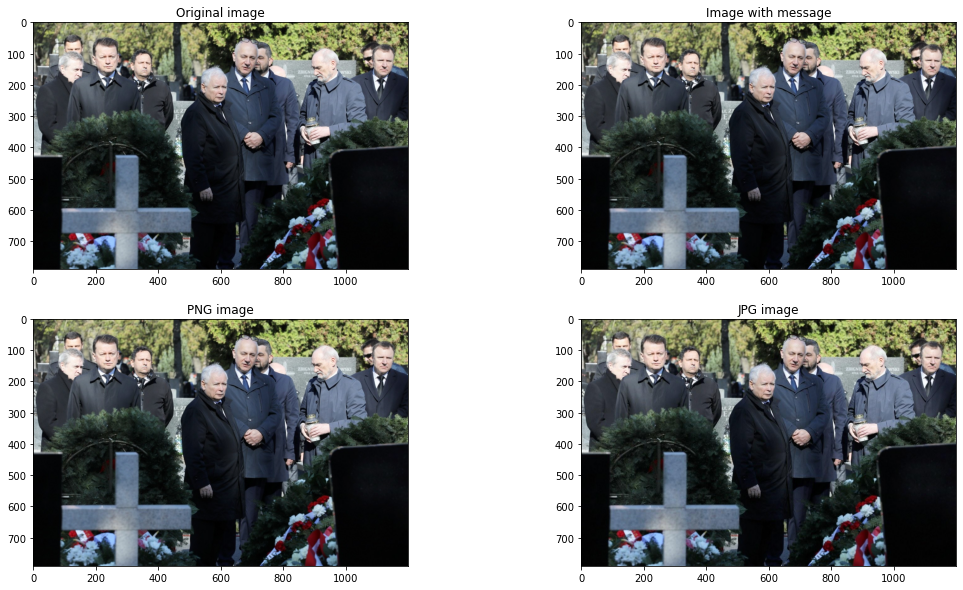

In [3]:
original_image = load_image("images/kaczynski.png")  # Wczytanie obrazka
# Mnożenie stringów działa jak zwielokratnianie
message = "Zostańcie w domach!" * 1
n = 2  # liczba najmłodszych bitów używanych do ukrycia wiadomości

message = encode_as_binary_array(message)  # Zakodowanie wiadomości jako ciąg 0 i 1
image_with_message, MSE1 = hide_message(original_image, message, n)  # Ukrycie wiadomości w obrazku

save_image("images/image_with_message.png", image_with_message)  # Zapisanie obrazka w formacie PNG
save_image("images/image_with_message.jpg", image_with_message)  # Zapisanie obrazka w formacie JPG

image_with_message_png = load_image("images/image_with_message.png")  # Wczytanie obrazka PNG
image_with_message_jpg = load_image("images/image_with_message.jpg")  # Wczytanie obrazka JPG

secret_message_png = decode_from_binary_array(
    reveal_message(image_with_message_png, nbits=n, length=len(message)))  # Odczytanie ukrytej wiadomości z PNG
secret_message_jpg = decode_from_binary_array(
    reveal_message(image_with_message_jpg, nbits=n, length=len(message)))  # Odczytanie ukrytej wiadomości z JPG

print(secret_message_png)
print(secret_message_jpg)

# Wyświetlenie obrazków
f, ar = plt.subplots(2,2)
ar[0,0].imshow(original_image)
ar[0,0].set_title("Original image")
ar[0,1].imshow(image_with_message)
ar[0,1].set_title("Image with message")
ar[1,0].imshow(image_with_message_png)
ar[1,0].set_title("PNG image")
ar[1,1].imshow(image_with_message_jpg)
ar[1,1].set_title("JPG image")

### 2. (3.5) Korzystając z kodu znajdującego się w punkcie Ukryjmy tekst w obrazku wygenerować i wyświetlić szerego obrazków z ukrytą wiadomością:

a) Wiadomość dla nbits=1 ma zajmować znakomitą większość obrazka (powyżej 75%).

b) Każdy kolejny obrazek należy generować z większą wartością nbits (do 8) - będzie 8 obrazków z wiadomością.

c) Dla każdego obrazka należy policzyć MSE z oryginałem.

d) Wartości MSE należy umieścić na wykresie (wykres ten należy wyświetlić w notebooku), w którym oś x stanowić będzie nbits.

e) Źródło tekstu jest dowolne, ale proponuję użyć czegoś w stylu (https://pypi.org/project/lorem/).

f) Do rysowania wykresu można wykorzystać funkcję matplotlib.pyplot.plot

secret: 2240000, nbits: 1, len_img * nbits = 2847600, stosunek: 78.66273352999016 %
MSE = 0.4993482142857143
secret: 2240000, nbits: 2, len_img * nbits = 5695200, stosunek: 39.33136676499508 %
MSE = 2.3039848214285716
secret: 2240000, nbits: 3, len_img * nbits = 8542800, stosunek: 26.22091117666339 %
MSE = 10.202611070262915
secret: 2240000, nbits: 4, len_img * nbits = 11390400, stosunek: 19.66568338249754 %
MSE = 37.40292142857143
secret: 2240000, nbits: 5, len_img * nbits = 14238000, stosunek: 15.732546705998033 %
MSE = 185.22749776785713
secret: 2240000, nbits: 6, len_img * nbits = 17085600, stosunek: 13.110455588331694 %
MSE = 619.9582572173978
secret: 2240000, nbits: 7, len_img * nbits = 19933200, stosunek: 11.237533361427166 %
MSE = 2498.493103125
secret: 2240000, nbits: 8, len_img * nbits = 22780800, stosunek: 9.83284169124877 %
MSE = 4344.707639285714


Text(0.5, 1.0, 'Nbits=8')

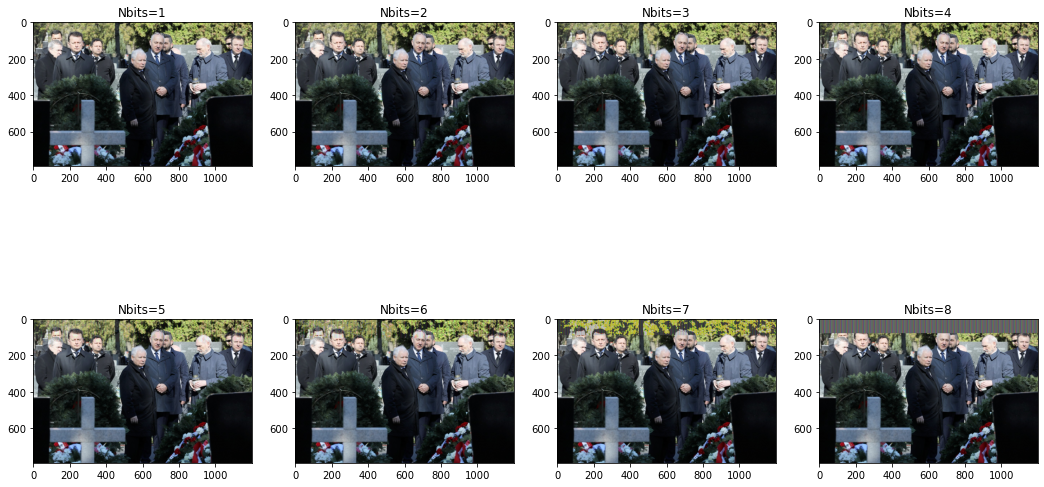

In [5]:
original_image = load_image("images/kaczynski.png")  # Wczytanie obrazka
# Mnożenie stringów działa jak zwielokratnianie
message = "Zostańcie w domach!" * 14000
message = encode_as_binary_array(message)  # Zakodowanie wiadomości jako ciąg 0 i 1

# Ukrycie wiadomości w obrazku
image_with_message1, MSE1 = hide_message(original_image, message, 1)  
image_with_message2, MSE2 = hide_message(original_image, message, 2)
image_with_message3, MSE3 = hide_message(original_image, message, 3)
image_with_message4, MSE4 = hide_message(original_image, message, 4)
image_with_message5, MSE5 = hide_message(original_image, message, 5)
image_with_message6, MSE6 = hide_message(original_image, message, 6)
image_with_message7, MSE7 = hide_message(original_image, message, 7)
image_with_message8, MSE8 = hide_message(original_image, message, 8)

# Wyświetlenie obrazków
f, ar = plt.subplots(2,4)
ar[0,0].imshow(image_with_message1)
ar[0,0].set_title("Nbits=1")
ar[0,1].imshow(image_with_message2)
ar[0,1].set_title("Nbits=2")
ar[0,2].imshow(image_with_message3)
ar[0,2].set_title("Nbits=3")
ar[0,3].imshow(image_with_message4)
ar[0,3].set_title("Nbits=4")
ar[1,0].imshow(image_with_message5)
ar[1,0].set_title("Nbits=5")
ar[1,1].imshow(image_with_message6)
ar[1,1].set_title("Nbits=6")
ar[1,2].imshow(image_with_message7)
ar[1,2].set_title("Nbits=7")
ar[1,3].imshow(image_with_message8)
ar[1,3].set_title("Nbits=8")


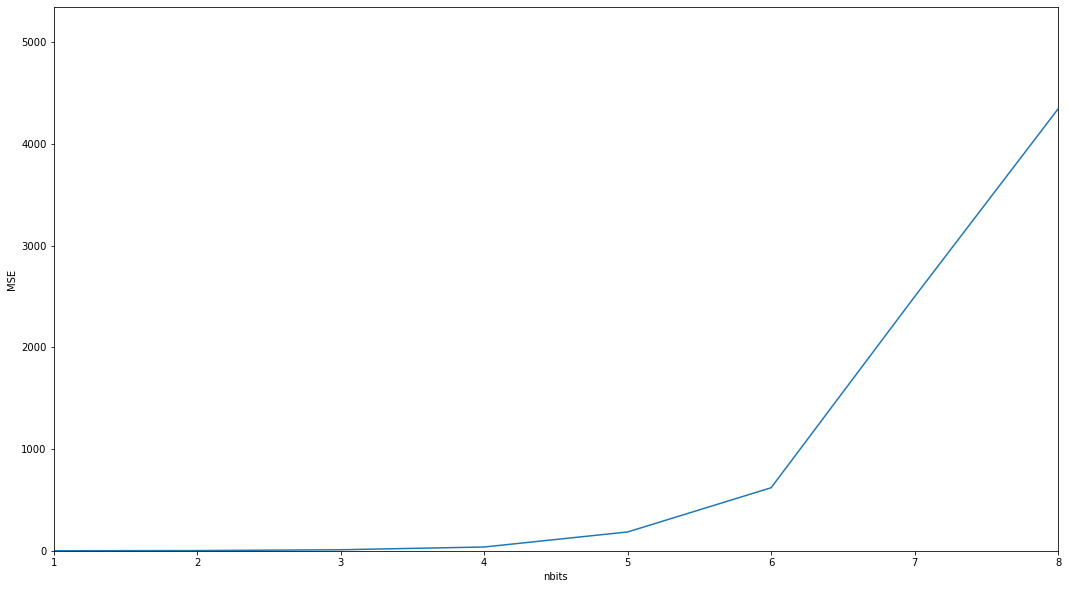

In [6]:
# Wykres MSE
plt.plot([MSE1, MSE1, MSE2, MSE3, MSE4, MSE5, MSE6, MSE7, MSE8])
plt.axis([1, 8, 0, MSE8 + 1000])
plt.ylabel('MSE')
plt.xlabel('nbits')
plt.show()

### 3. (4.0) Przerobić funkcje reveal_message i hide_message z punktu Zmiana wartości pikseli w taki sposób, aby pozwalały zapisywać i odczytywać wiadomość zaczynająć od zadanej pozycji (funkcje można napisać od nowa, ale wyjście ma pozostać niezmienione). Sygnatury funkcji powinny wyglądać następująco (spos to pozycja początkowa):

a) def hide_message(image, message, nbits=1, spos=0)

b) def reveal_message(image, nbits=1, length=0, spos=0)

In [7]:
"""Function definitions that are used in LSB steganography."""
from matplotlib import pyplot as plt
import numpy as np
import binascii
import cv2 as cv
import math
import struct
plt.rcParams["figure.figsize"] = (18,10)


def encode_as_binary_array(msg):
    """Encode a message as a binary string."""
    msg = msg.encode("utf-8")
    msg = msg.hex()
    msg = [msg[i:i + 2] for i in range(0, len(msg), 2)]
    msg = [bin(int(el, base=16))[2:] for el in msg]
    msg = ["0" * (8 - len(el)) + el for el in msg]
    return "".join(msg)


def decode_from_binary_array(array):
    """Decode a binary string to utf8."""
    array = [array[i:i+8] for i in range(0, len(array), 8)]
    if len(array[-1]) != 8:
        array[-1] = array[-1] + "0" * (8 - len(array[-1]))
    array = [hex(int(el, 2))[2:].zfill(2) for el in array]
    array = "".join(array)
    result = binascii.unhexlify(array)
    return result.decode("utf-8", errors="replace")


def load_image(path, pad=False):
    """Load an image.
    
    If pad is set then pad an image to multiple of 8 pixels.
    """
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    if pad:
        y_pad = 8 - (image.shape[0] % 8)
        x_pad = 8 - (image.shape[1] % 8)
        image = np.pad(
            image, ((0, y_pad), (0, x_pad) ,(0, 0)), mode='constant')
    return image


def save_image(path, image):
    """Save an image."""
    plt.imsave(path, image) 


def clamp(n, minn, maxn):
    """Clamp the n value to be in range (minn, maxn)."""
    return max(min(maxn, n), minn)


def hide_message(image, message, nbits=1, spos=0):
    """Hide a message in an image (LSB).
    
    nbits: number of least significant bits
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > len(image) * nbits:
        raise ValueError("Message is to long :(")
    
    print('secret: {}, nbits: {}, len_img * nbits = {}, stosunek: {} %'.format(len(message),nbits, len(image)*nbits, 100*len(message)/(len(image)*nbits)))
    chunks = [message[i:i + nbits] for i in range(spos*8, len(message), nbits)]
    count = 0
    tmp = 0
    MSE = 0
    for i, chunk in enumerate(chunks):
        byte = str(bin(image[i]))[2:].zfill(8)
        new_byte = byte[:-nbits] + chunk
        image[i] = int(new_byte, 2) 
        tmp += pow(int(byte,2) - int(new_byte,2), 2)
        count = count + 1
    MSE = tmp/count
    print('MSE = {}'.format(MSE))
    return image.reshape(shape), MSE


def reveal_message(image, nbits=1, length=0, spos=0):
    """Reveal the hidden message.
    
    nbits: number of least significant bits
    length: length of the message in bits.
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image)
    
    message = ""
    i = spos*4
    while i < length_in_pixels:
        byte = str(bin(image[i]))[2:].zfill(8)
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message

In [8]:
original_image = load_image("images/kaczynski.png")  # Wczytanie obrazka
# Mnożenie stringów działa jak zwielokratnianie
message = "Zostańcie w domach!" * 1
n = 2  # liczba najmłodszych bitów używanych do ukrycia wiadomości
writePos = 0
readPos = 0

message = encode_as_binary_array(message)  # Zakodowanie wiadomości jako ciąg 0 i 1
image_with_message, MSE1 = hide_message(original_image, message, n, spos=writePos)  # Ukrycie wiadomości w obrazku

save_image("images/image_with_message.png", image_with_message)  # Zapisanie obrazka w formacie PNG

image_with_message_png = load_image("images/image_with_message.png")  # Wczytanie obrazka PNG

secret_message_png = decode_from_binary_array(
    reveal_message(image_with_message_png, nbits=n, length=len(message),spos=readPos))  # Odczytanie ukrytej wiadomości z PNG

print(secret_message_png)


secret: 160, nbits: 2, len_img * nbits = 5695200, stosunek: 0.0028093833403567917 %
MSE = 2.3625
Zostańcie w domach!


### (4.5) Napisać program, który odzyska obrazek z obrazka zapisanego w punkcie 'Ukryjmy obrazek w obrazku'. Funkcja dekodująca (odnajdująca wiadomość) powinna przyjmować następujące parametry:

a) image - obrazek z ukrytym obrazkiem

b) length - długość ukrytego obrazka

c) nbits - liczba najmłodszych bitów użyta do zakodowania obrazka

In [17]:
"""Function definitions that are used in LSB steganography."""
from matplotlib import pyplot as plt
import numpy as np
import binascii
import cv2 as cv
import math
import struct
import itertools 
plt.rcParams["figure.figsize"] = (18,10)


def encode_as_binary_array(msg):
    """Encode a message as a binary string."""
    msg = msg.encode("utf-8")
    msg = msg.hex()
    msg = [msg[i:i + 2] for i in range(0, len(msg), 2)]
    msg = [bin(int(el, base=16))[2:] for el in msg]
    msg = ["0" * (8 - len(el)) + el for el in msg]
    return "".join(msg)


def decode_from_binary_array(array):
    """Decode a binary string to utf8."""
    array = [array[i:i+8] for i in range(0, len(array), 8)]
    if len(array[-1]) != 8:
        array[-1] = array[-1] + "0" * (8 - len(array[-1]))
    array = [hex(int(el, 2))[2:].zfill(2) for el in array]
    array = "".join(array)
    result = binascii.unhexlify(array)
    return result.decode("utf-8", errors="replace")


def load_image(path, pad=False):
    """Load an image.
    
    If pad is set then pad an image to multiple of 8 pixels.
    """
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    if pad:
        y_pad = 8 - (image.shape[0] % 8)
        x_pad = 8 - (image.shape[1] % 8)
        image = np.pad(
            image, ((0, y_pad), (0, x_pad) ,(0, 0)), mode='constant')
    return image


def save_image(path, image):
    """Save an image."""
    plt.imsave(path, image) 


def clamp(n, minn, maxn):
    """Clamp the n value to be in range (minn, maxn)."""
    return max(min(maxn, n), minn)


def hide_message(image, message, nbits=1):
    """Hide a message in an image (LSB).
    
    nbits: number of least significant bits
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > len(image) * nbits:
        raise ValueError("Message is to long :(")
    
    print('secret: {}, nbits: {}, len_img * nbits = {}, stosunek: {} %'.format(len(message),nbits, len(image)*nbits, 100*len(message)/(len(image)*nbits)))
    
    chunks = [message[i:i + nbits] for i in range(0, len(message), nbits)]
    for i, chunk in enumerate(chunks):
        byte = str(bin(image[i]))[2:].zfill(8)
        new_byte = byte[:-nbits] + chunk
        image[i] = int(new_byte, 2) 
    return image.reshape(shape)


def reveal_message(image, nbits=1, length=0):
    """Reveal the hidden message.
    
    nbits: number of least significant bits
    length: length of the message in bits.
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image)
    
    message = ""
    i = 0
    while i < length_in_pixels:
        byte = str(bin(image[i]))[2:].zfill(8)
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message

secret: 191568, nbits: 1, len_img * nbits = 2071440, stosunek: 9.248059321052022 %


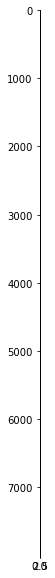

In [79]:
def hide_image(image, secret_image_path, nbits=1):
    with open(secret_image_path, "rb") as file:
        secret_img = file.read()
    secret_img = secret_img.hex()
    secret_img = [secret_img[i:i + 2] for i in range(0, len(secret_img), 2)]
    secret_img = [bin(int(el, base=16))[2:].zfill(8) for el in secret_img]
    secret_img = "".join(secret_img)
    return hide_message(image, secret_img, nbits), len(secret_img)

def retrieve_image(image, length, nbits=1):
    secret = reveal_message(image, nbits, length)
    secret_img = [int(secret[i:i+8],2) for i in range(0, len(secret), 8)]
    secret_img = np.array(secret_img)
    
    # nieskonczone, wiec nie dziala
    secret_img = np.reshape(secret_img, (int(len(secret_img)/3),3))
    return secret_img
    
nbits_tmp = 1
image = load_image("images/rembrandt.png")
image_with_secret, length_of_secret = hide_image(image, "images/spanish.jpg", nbits_tmp)
secret_only = retrieve_image(image_with_secret, length_of_secret, nbits_tmp)

plt.imshow(secret_only)